# 1)Загрузка и обратотка датасета

In [1]:
# путь до данных на компьютере
path = 'train_data/'

In [1]:
# импорты
import pandas as pd
import os
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [3]:
# список категориальных признаков (для ohe кодирования)
categorical_features = ['pre_since_opened','pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
               'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
               'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3',
               'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10',
               'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
               'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
               'enc_loans_account_holder_type','enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur', 
               'pre_loans_total_overdue', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 
               'is_zero_loans6090',  'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit','pclose_flag', 'fclose_flag'
               ]

In [4]:
# список бинарных признаков(+ id и rn)
Bin_feats = ['id','rn' ]

In [5]:
#Ф-ция для создания датафрейма с категориальными признаками
def categorical_select(data):
    return data[categorical_features]
categorical_selector = FunctionTransformer(categorical_select, validate=False)

In [6]:
#Ф-ция для создания датафрейма с некатегориальными признаками(+ id и rn)
def bin_select(data):
    return data[Bin_feats]
bin_selector = FunctionTransformer(bin_select, validate=False)

In [8]:
# Кастомный OHE, который выводит датафрейм, а не матрицу
ohe = OneHotEncoder()
class OneHotEncodingDf(OneHotEncoder):
    """DataFrame Wrapper around OneHotEncoding"""
    def __init__(self, drop=None, sparse=False, handle_unknown='ignore'):
        super(OneHotEncodingDf, self).__init__(drop=drop,
                                               sparse=sparse,
                                               handle_unknown=handle_unknown
                                              )

    def transform(self, X, y=None):
        z = super(OneHotEncodingDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=self.get_feature_names_out())
    
ohe_df = OneHotEncodingDf()

In [9]:
# Препроцессор для категориальных признаков
categorical_preprocessor = Pipeline([
    ("categorical_selector", categorical_selector),
    ("ohe", ohe_df)
])

In [11]:
# Препроцессор для некатегориальных признаков(+ id и rn)
bin_preprocessor = Pipeline([
    ("bin_selector", bin_selector)
])

In [3]:
# Ф-ци агрегации, для суммирования значений по id, подсчета количества rn(кредитных продуктов)
def agg_func(data):
    cols = data.columns[2:]
    aggregation_dict = {col: 'sum' for col in cols}
    data = data.groupby('id').agg({'rn': 'count', **aggregation_dict}).astype(np.int16).reset_index()
    return data
agg_sum_func = FunctionTransformer(agg_func, validate=False)

In [13]:
# препроцессор для агрегации
agg_sum_preprocessor = Pipeline([
    ("aggregation", agg_sum_func)
])

In [14]:
# Кастомный Union, чтобы на выходе получать датафрейм, а не матрицу.
from joblib import Parallel, delayed 
from scipy import sparse

from sklearn.pipeline import (
    _fit_transform_one,
    _transform_one,
)

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [15]:
# Union для параллельной обработки категориальных и некатегориальных признаков 
feature_union = PandasFeatureUnion([
    ("bin_preprocessor", bin_preprocessor),
    ("categorical_preprocessor", categorical_preprocessor)
])

In [16]:
# итоговый пайплайн для предобработки загружаемых данных(сразу возвращает датафрейм, а не матрицу)
prepare_dataset = Pipeline([
    ("preprocessing", feature_union),
    ("aggregation", agg_sum_preprocessor) 
])

In [17]:
# функция для обработки пропусков и удаления колонки id, после мерджа с целнвой переменной
from sklearn.impute import SimpleImputer

def replace_missing_with_zero(df):
    columns_with_missing_values = df.columns[df.isnull().any()].tolist()

    imputer = SimpleImputer(strategy='constant', fill_value=0)

    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

    return df.drop(columns=['id'])

replace_Nan_func = FunctionTransformer(replace_missing_with_zero, validate=False)

In [18]:
# препроцессор для замены пропусков в итоговом датасете
replace_Nan_preprocessor = Pipeline([
    ("remove_Nan", replace_Nan_func)
])

In [7]:
# читаем датасет

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [4]:
# Собираем итогововый датасет для мерджа с целевой переменной с предобработкой
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных
        transactions_frame = prepare_dataset.fit_transform(transactions_frame) #га выгоде получаем датасет после ohe и агрегации

   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames) 

#### Так как данные закодированы, то хоть они и представлены числами, но по факту они являются категориальными, так как у нас нет даже информации о том, что они означают, кроме бинарных признаков, где можно предположить, что 1 это наличие, 0 это отсутствие. Поэтому для предварительного анализа я сгрупировал данные по id. А для построения модели применил ohe всех признаков(кроме rn, так как при агрегации он показывает количество кредитов по каждому id)

In [ ]:
# Собираем датасет из частей
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once = 1,
                                     num_parts_total = 1)

In [90]:
# проверка на нанличие пропусков
missing = []
for i in data.columns:    
    if data[i].isna().sum() > 0:
        print(i, data[i].isna().sum())
        missing.append(i)
   

In [ ]:
# читаем целевую переменную
targets = pd.read_csv('train_target.csv')
targets.head()

In [ ]:
# мердж с целевой переменной
df_merged = data.merge(targets[['id', 'flag']], on='id')
df_merged

In [ ]:
# Заполняем признаки с пустыми строками и удаляем id
df_merged = replace_Nan_preprocessor.fit_transform(df_merged)

In [43]:
for i in df_merged.columns:
    if df_merged[i].isna().sum() > 0:
        print(i, df_merged[i].isna().sum())

In [42]:
df_merged.to_parquet('df_merged_final.parquet')

In [16]:
df_merged = pd.read_parquet('df_merged_final.parquet')

## 2)Визуализация

In [13]:
# Ф-ци агрегации, для суммирования значений по id, подсчета количества rn(кредитных продуктов)
def agg_func(data):
    cols = data.columns[2:]
    aggregation_dict = {col: 'sum' for col in cols}
    data = data.groupby('id').agg({'rn': 'count', **aggregation_dict}).astype(np.int16).reset_index()
    return data

In [15]:
# Ф-ция для сборки датасета для разведочного анализа
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных
        transactions_frame = agg_func(transactions_frame) #га выгоде получаем датасет после ohe и агрегации

   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames) 

In [16]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once = 1,
                                     num_parts_total = 12)

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq


In [18]:
targets = pd.read_csv('train_target.csv')
targets.head()
df_mer = data.merge(targets[['id', 'flag']], on='id')
df_mer

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
0              0  10                81                   76         71   
1              1  14               160                  107         93   
2              2   3                25                   32         21   
3              3  15               105                  110        114   
4              4   1                12                    9          4   
...          ...  ..               ...                  ...        ...   
2999995  2499995  14               177                   80        101   
2999996  2499996   5                17                   58         61   
2999997  2499997  14               150                  104        144   
2999998  2499998   7                71                   68         29   
2999999  2499999  15               104                  123        102   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               75              114              107                      96   
1              111              141               98                     114   
2               18               15               27                       5   
3              117               78              122                     148   
4                8                1               11                      12   
...            ...              ...              ...                     ...   
2999995        114              124              145                     113   
2999996         31               49               36                      71   
2999997        100               79              133                     151   
2999998         62               56               65                      91   
2999999        139               85              126                     152   

         pre_loans_next_pay_summ  ...  enc_paym_22  enc_paym_23  enc_paym_24  \
0                             31  ...           24           24           40   
1                             30  ...           34           33           47   
2                              4  ...            7            7           12   
3                             39  ...           24           24           45   
4                              1  ...            3            3            4   
...                          ...  ...          ...          ...          ...   
2999995                       29  ...           39           39           53   
2999996                       10  ...           15           15           20   
2999997                       24  ...           27           27           41   
2999998                       11  ...            9            9           19   
2999999                       30  ...           42           45           60   

         enc_loans_account_holder_type  enc_loans_credit_status  \
0                                   10                       26   
1                                   14                       38   
2                                    3                        7   
3                                   15                       38   
4                                    1                        2   
...                                ...                      ...   
2999995                             14                       40   
2999996                              5                       12   
2999997                             14                       37   
2999998                              7                       17   
2999999                             15                       43   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
0                           35                     10            1   
1                           44                     14            1   
2                           10                      3            2   
3                           54                     15            5   
4                            3                  

In [29]:
print('Количество 0 в flag = ', len(df_mer[df_mer.flag == 0]), 
      '\nКоличество 1 в flag = ', len(df_mer[df_mer.flag == 1]))

Количество 0 в flag =  2893558 
Количество 1 в flag =  106442


<Axes: >

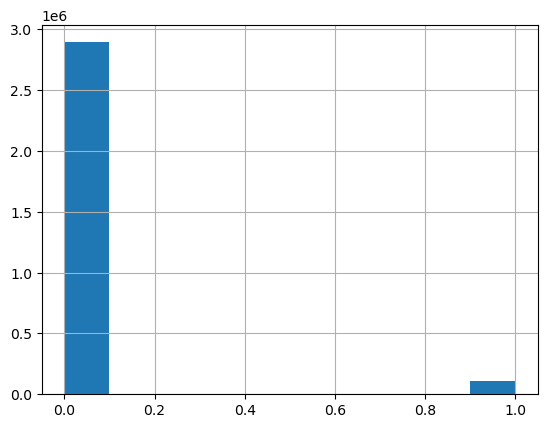

In [36]:
df_mer['flag'].hist()

### Выборка не сбалансированная
### Проверим гипотезу, что чем больше кредитов, тем больше количсетво просрочек свыше 90 дней

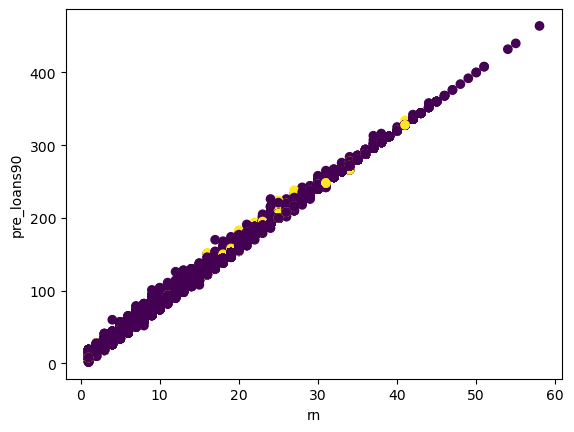

In [53]:
plt.scatter(df_mer['rn'], df_mer['pre_loans90'], c=df_mer['flag'])
plt.xlabel('rn')
plt.ylabel('pre_loans90')
plt.show()

##### чем меньше кредитов, тем меньше просрочек до 5дней, однако дефолтные кредиты присутствуют и у людей, которые брали мало кредитов.

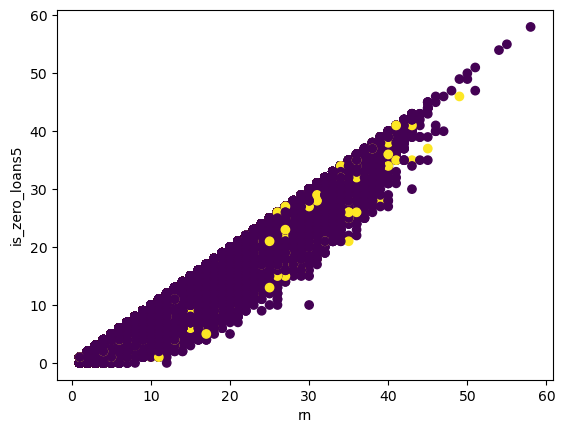

In [75]:
plt.scatter(df_mer['rn'], df_mer['is_zero_loans5'], c=df_mer['flag'])
plt.xlabel('rn')
plt.ylabel('is_zero_loans5')
plt.show()

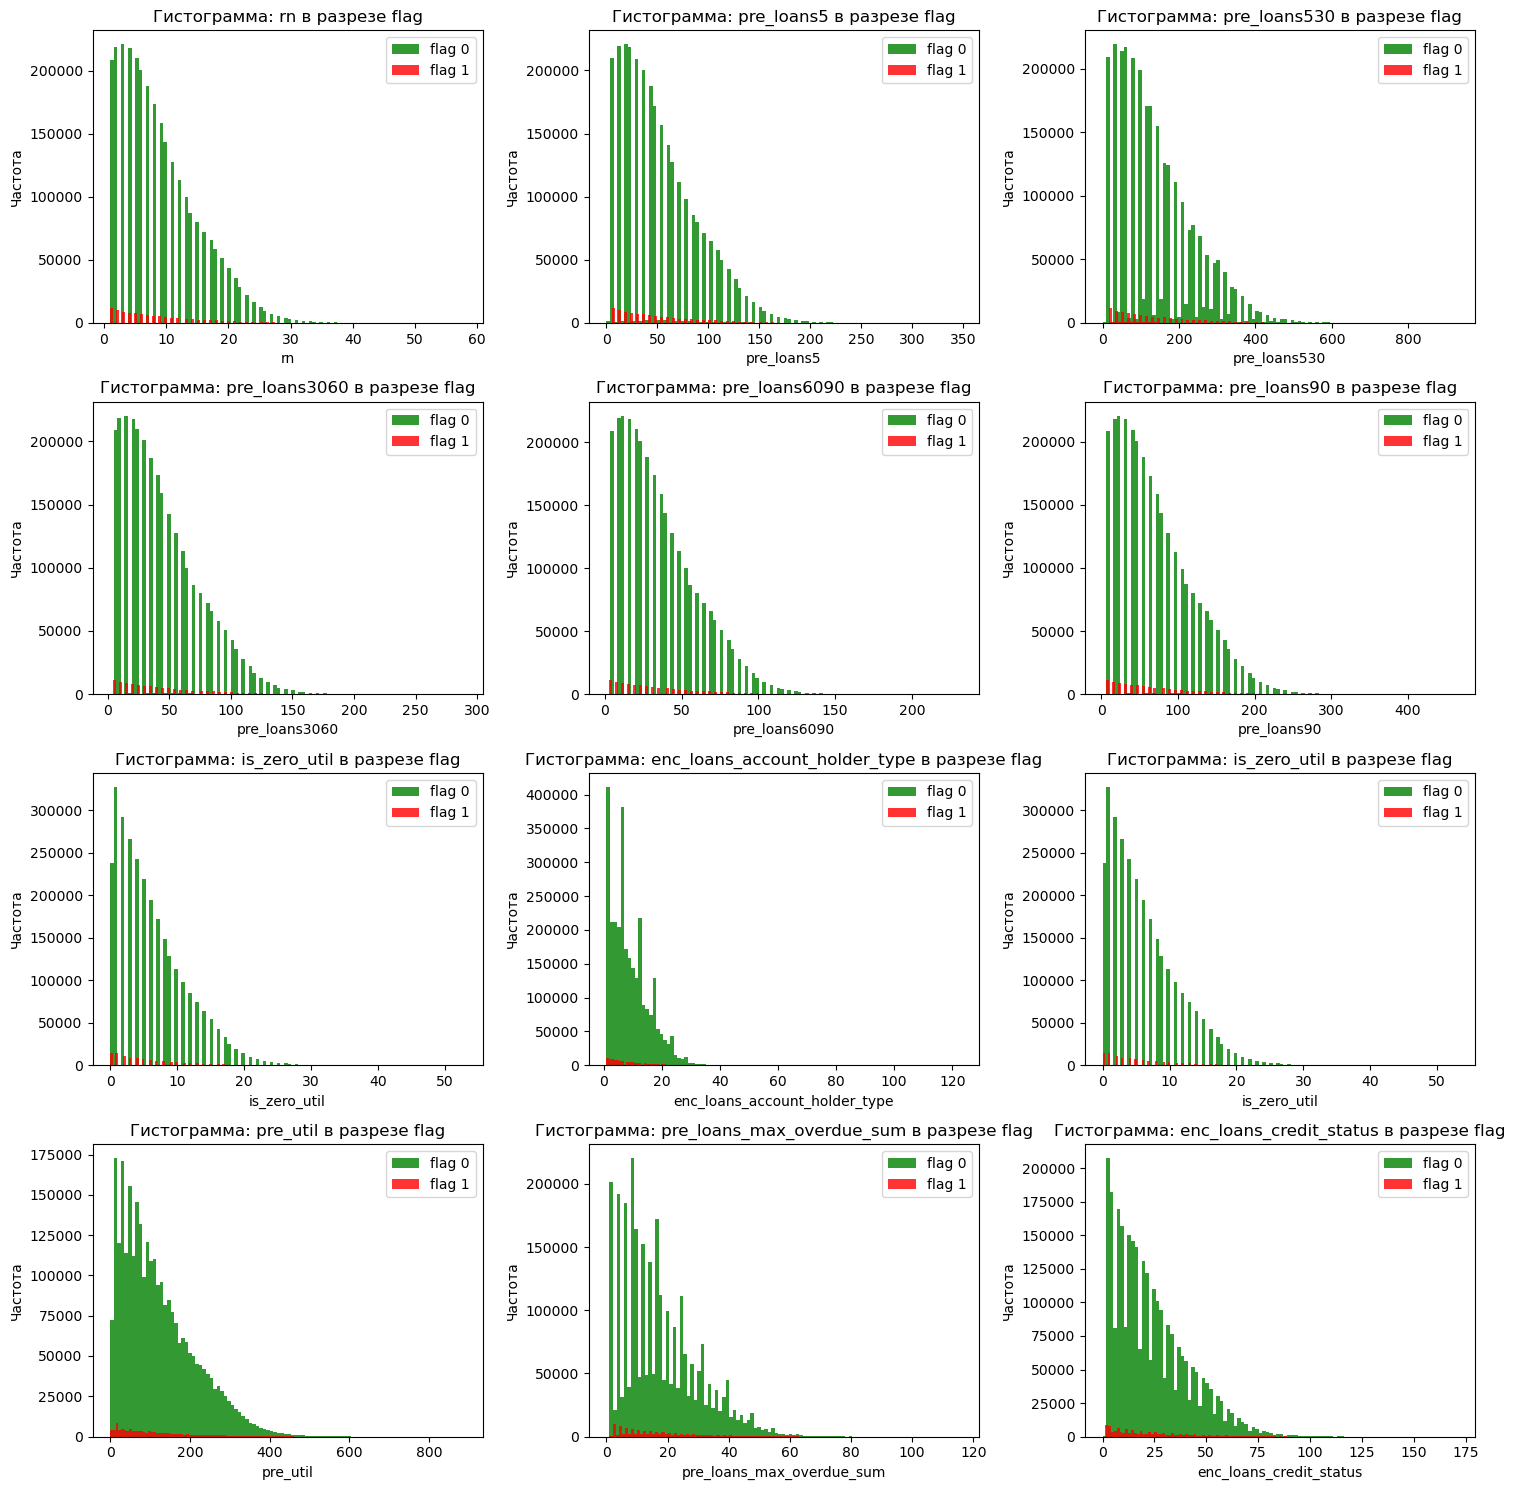

In [84]:
# Получаем уникальные значения "flag"
unique_flags = df_mer['flag'].unique()

# Создаем гистограмму для каждого уникального значения "flag"
cols = ['rn', 'pre_loans5', 'pre_loans530','pre_loans3060','pre_loans6090', 'pre_loans90', 'is_zero_util',
        'enc_loans_account_holder_type', 'is_zero_util', 'pre_util', 'pre_loans_max_overdue_sum', 'enc_loans_credit_status']

fig, ax = plt.subplots(4, 3, figsize=(15, 15))  # Создаем общую область для графиков

for i, col in enumerate(cols):
    for j, flag in enumerate(unique_flags):
        if flag == 1:
            color = 'r'  # Красный цвет
        else:
            color = 'g'  # Зеленый цвет
        ax[i//3, i%3].hist(df_mer[df_mer['flag'] == flag][col], alpha=0.8, label=f'flag {flag}', bins=100, color=color)  # Построение гистограммы
        ax[i//3, i%3].set_xlabel(col)
        ax[i//3, i%3].set_ylabel('Частота')
        ax[i//3, i%3].set_title(f'Гистограмма: {col} в разрезе flag')
        ax[i//3, i%3].legend()

plt.tight_layout()
plt.show()

### Можно сделать вывод, что процент дефолтных кредитов увеличивается с увеличением количества просрочек(на любой срок), чем больше количество просрочек, тем меньшее количество клиентов их допускали, причем это количество падает намного сильнее, чем количсетво дефолтных кредитов. Поэтому можно сделдать вывод, что чем больше просрочек, тем больше вероятность дефолта, как и вреальной жизни.
### Так же, чем больше кредитов, тем больше вероятность дефолта.
### Чем больше сумма просрочки к основному долгу, тем больше вероятность дефолта.

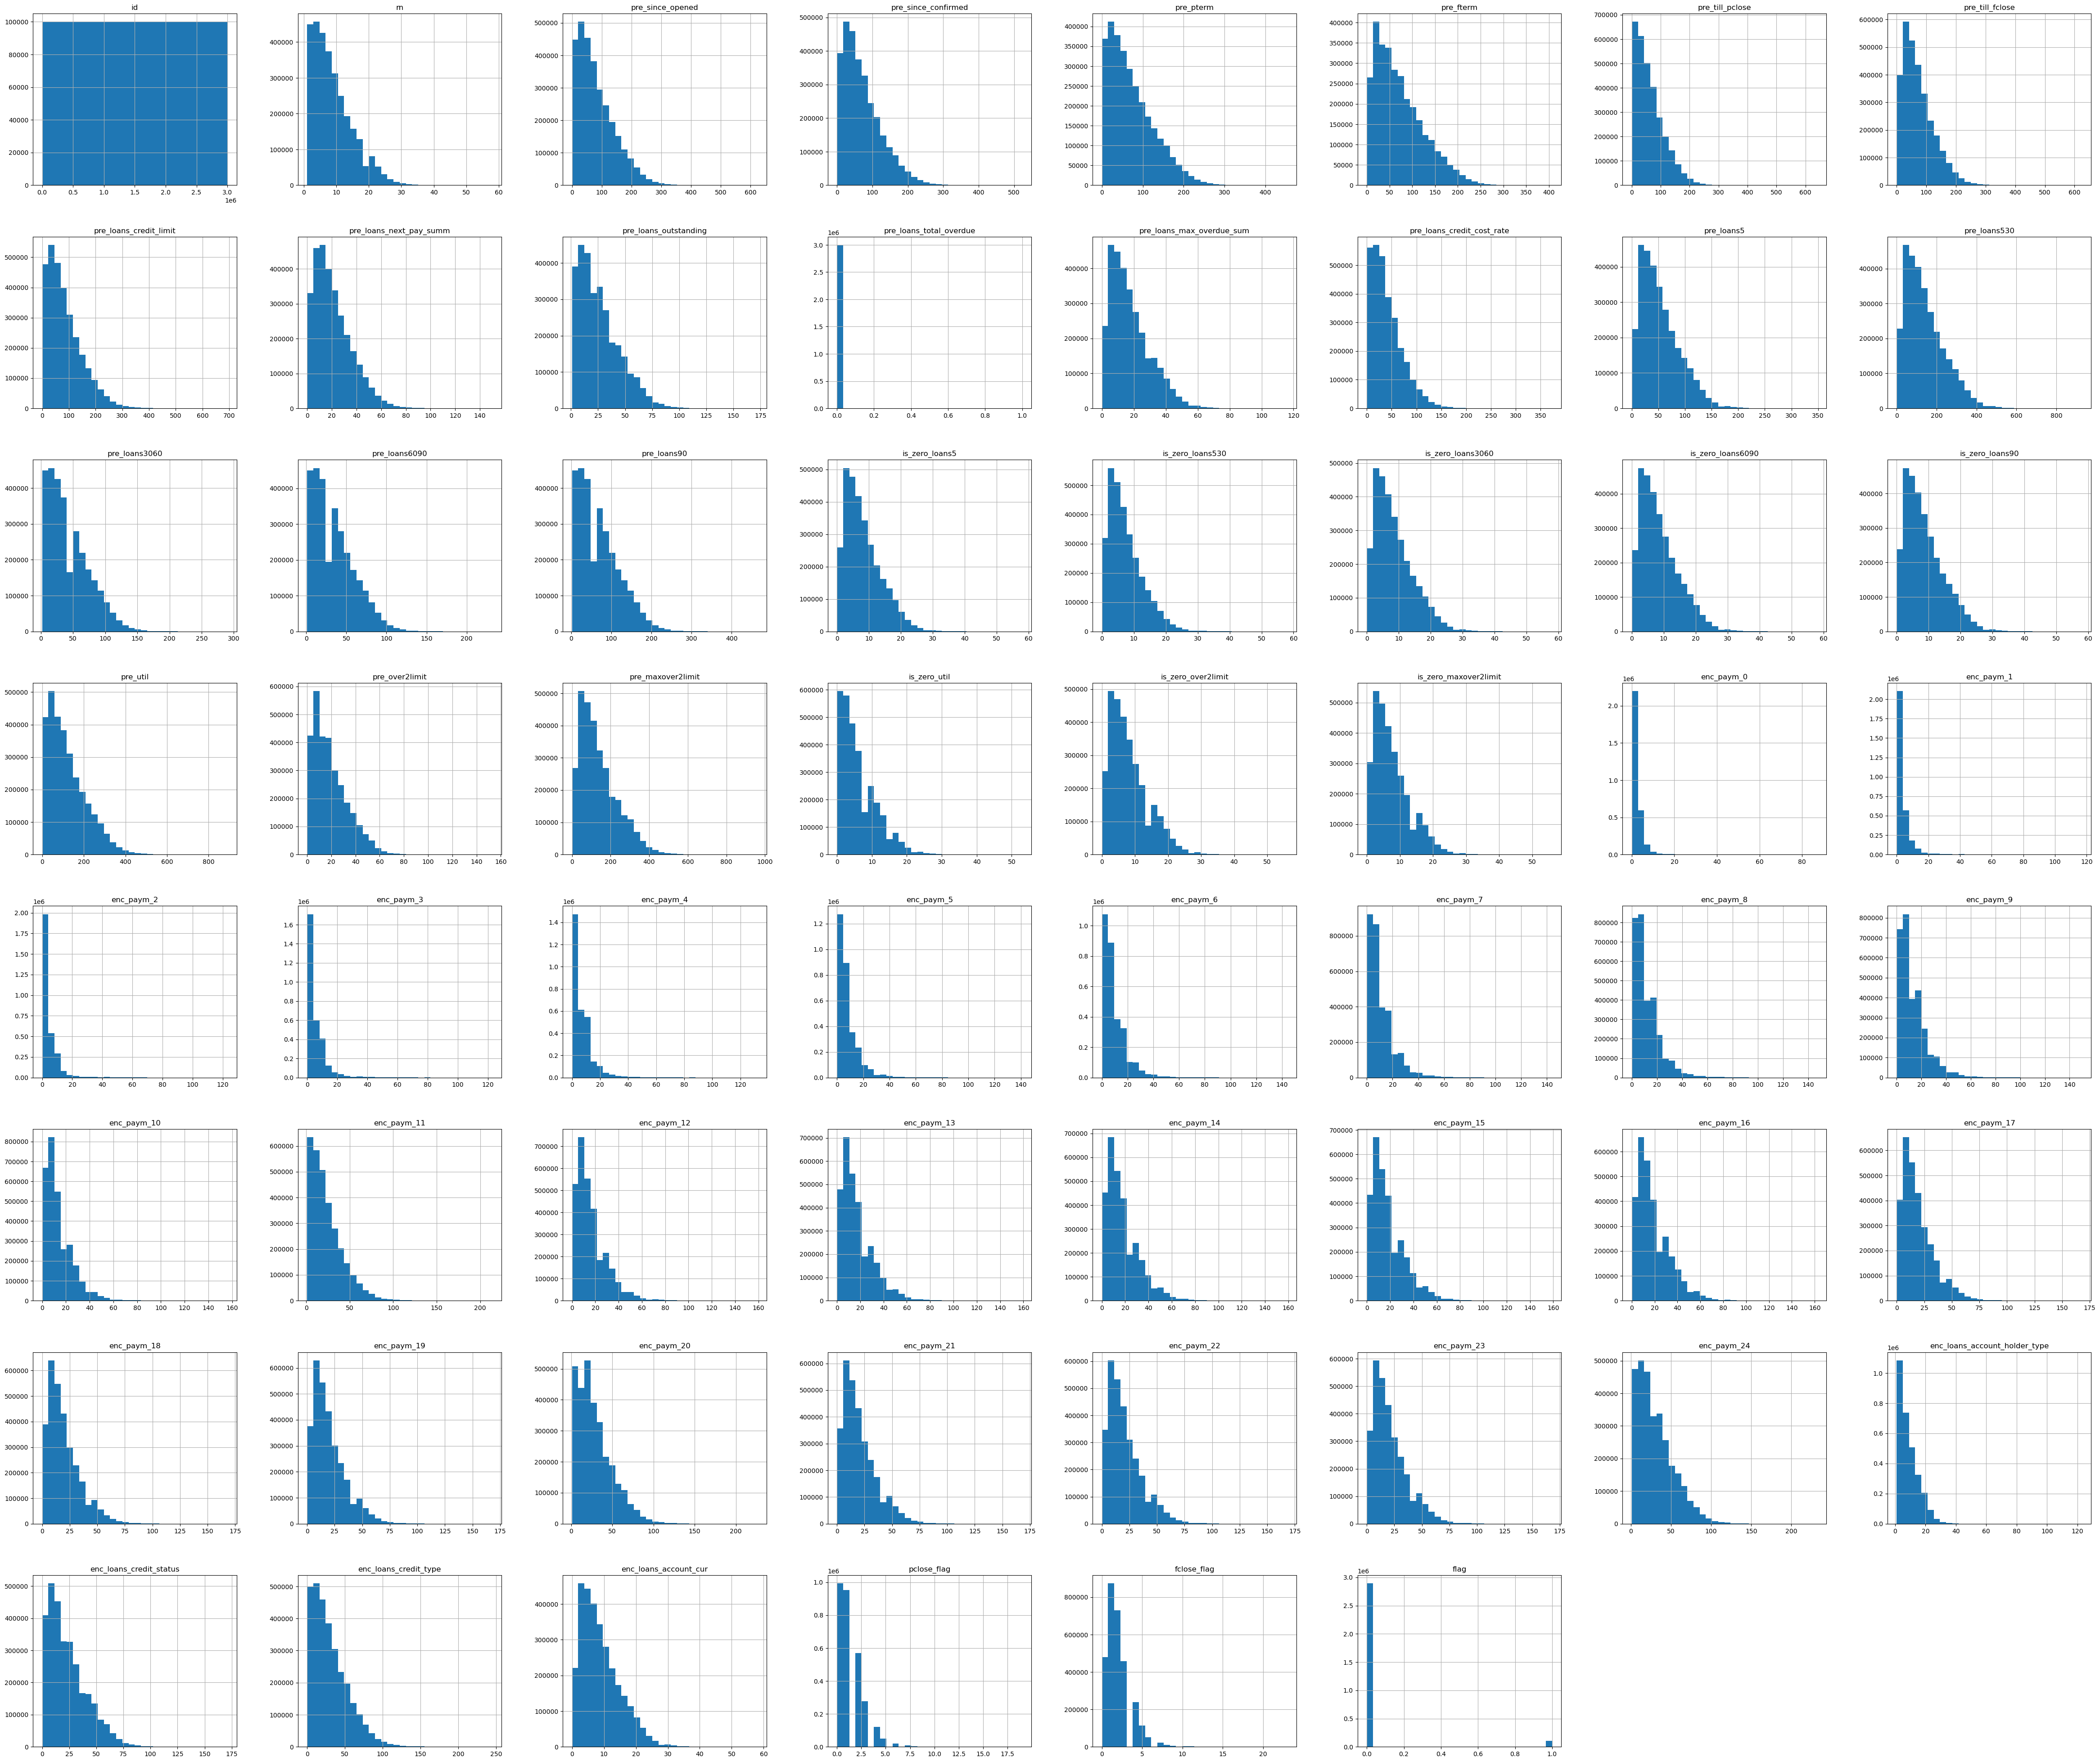

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
df_mer.hist(figsize=(59, 50), bins = 30)

plt.show()

### распределения в большинстве случаев похожи

<Axes: >

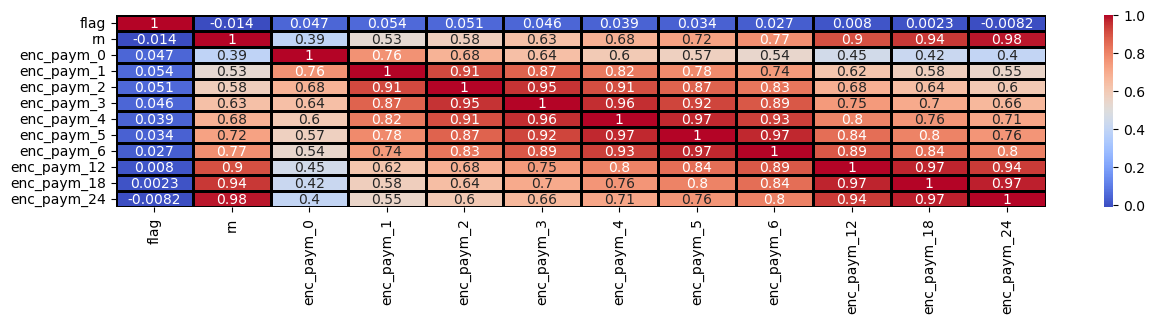

In [103]:
import seaborn as sns
cols_to_corr_enc_paym =  [
                          'flag','rn', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 
                          'enc_paym_5', 'enc_paym_6',  'enc_paym_12', 'enc_paym_18', 'enc_paym_24'
                          ]

fig, ax = plt.subplots(figsize=(15, 2.5))
sns.heatmap(df_mer[cols_to_corr_enc_paym].corr(), annot = True,cmap= 'coolwarm', linewidths=1, linecolor='black')

### У целевой переменной очень слабая линейная зависимость от статусов платежей за последние 24 мес.

<Axes: >

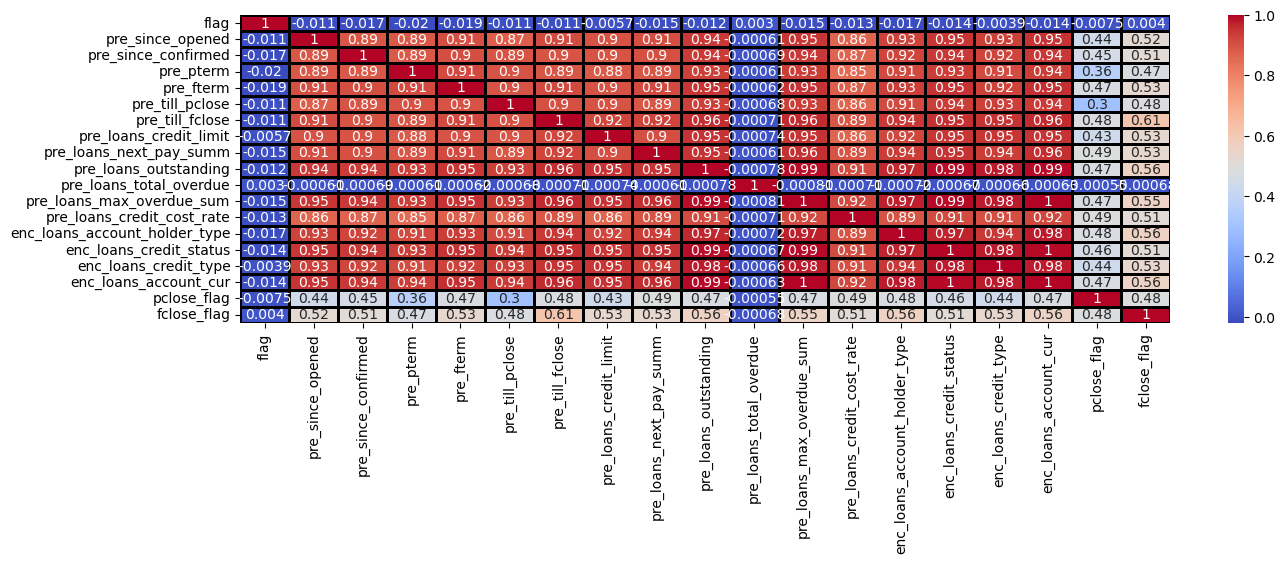

In [102]:
cols_to_corr =  [ 
                'flag', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose',
                'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 
                'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate',  
                'enc_loans_account_holder_type', 'enc_loans_credit_status', 'enc_loans_credit_type',
                'enc_loans_account_cur', 'pclose_flag', 'fclose_flag'
                ]

fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(df_mer[cols_to_corr].corr(), annot = True,cmap= 'coolwarm', linewidths=1, linecolor='black')

### Так же наблюдаем очень слабую корреляцию

<Axes: >

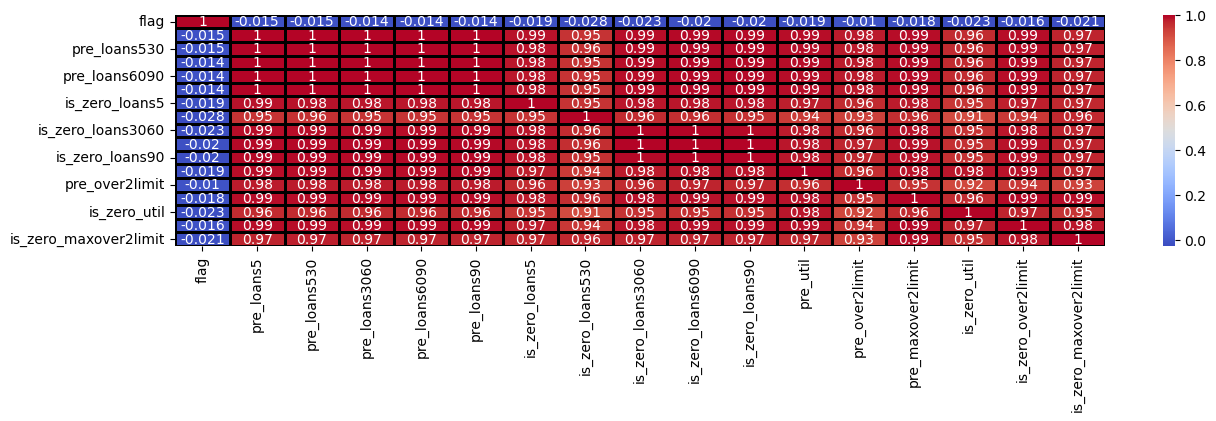

In [101]:
cols_to_corr =  [ 
                'flag',  'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
                'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090',
                'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit',
                'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'
                ]

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_mer[cols_to_corr].corr(), annot = True,cmap= 'coolwarm', linewidths=1, linecolor='black')

### Так же наблюдаем очень слабую корреляцию

# Вывод
### Так как корреляция очень слабая у признаков с целевой переменной, то здесь скорее всего лучше сработают бустинговые модели либо рекурентная модель, полагаю это потому, что данные по сути являются категориальными(последовательными).

# 3) Делим выборку на Train и Test и делаем downsampling(так как выборка очень не сбалансированная и данных много)

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

data_train, data_test = train_test_split(df_merged, test_size=0.2, stratify=df_merged['flag'], random_state=RANDOM_SEED)

In [11]:
data_test.to_parquet('data_test_final.parquet')

In [6]:
from sklearn.utils import resample

df_min = data_train[data_train['flag'] == 1]
df_maj = data_train[data_train['flag'] == 0]

In [7]:
RANDOM_SEED = 1
df_maj_downsample = resample(df_maj, replace=False, n_samples=len(df_min), random_state=RANDOM_SEED)

print(df_maj_downsample.shape)
print(df_min.shape)

(85154, 410)
(85154, 410)


In [8]:
df_2 = pd.concat([df_maj_downsample, df_min], ignore_index=True).sample(frac=1.)
df_2.to_parquet('df_2_final.parquet')# выборка не стандартизированная с даунсемплом

# 4) ML

In [3]:
import numpy as np
df_2 = pd.read_parquet('df_2_final.parquet')
X_train, y_train = df_2[df_2.columns.tolist()[:-1]].astype(np.int16), df_2['flag'].astype(np.int16)

In [4]:
data_test = pd.read_parquet('data_test_final.parquet')
X_test, y_test = data_test[data_test.columns.tolist()[:-1]].astype(np.int16), data_test['flag'].astype(np.int16)

In [23]:
data_full  = pd.read_parquet('df_merged_final.parquet').astype(np.int16)

#### Определяем признаки и целевую переменную

In [ ]:
target = ['flag']  # целевая переменная

# Бинарные признаки
bin_features = [
    col for col in df_2.columns if (df_2[col].nunique() == 2) & (col not in target)
]

# Числовые признаки
numerical_features = [
    col for col in df_2.columns if  col not in bin_features + target + id
]

all_features = bin_features + numerical_features
len(all_features)

#### Импорты

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def bin_select(data):
    return data
bin_selector = FunctionTransformer(bin_select, validate=False)

In [8]:
numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all"))
])
bin_transformer = Pipeline([
    ("bin_selector", bin_selector)
])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("bin", bin_transformer, bin_features)
])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

#### Создаем пайплайн для XGBClassifier

In [13]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier() 
XGBClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", XGBClassifier())])

score = cross_val_score(XGBClassifier_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f'model: {type(XGBClassifier).__name__}, roc_auc_mean: {score.mean():.4f}, roc_auc_std: {score.std():.4f}')

model: type, roc_auc_mean: 0.7514, roc_auc_std: 0.0020


In [14]:
score = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f'model: {type(XGBClassifier).__name__}, roc_auc_mean: {score.mean():.4f}, roc_auc_std: {score.std():.4f}')

model: type, roc_auc_mean: 0.7512, roc_auc_std: 0.0017


#### Смысла в стандартизации для проведения исследований нету, результат практически тот же, время выполнения выше.

In [20]:
xgb_model = XGBClassifier()
param_grid = {
    'classifier__max_depth': [5, 21, 2],
    'classifier__learning_rate': [0.1, 0.01, 0.05],
    'classifier__n_estimators': [100, 1000, 200],
    'classifier__subsample': [0.5, 1, 0.1],
    'classifier__colsample_bytree': [0.5, 1, 0.1]
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=kfold) 
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)

###### Прверяем на всей выборке

In [28]:
model = XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 5, n_estimators= 300, subsample= 0.7)

score = cross_validate(model, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')

print(f"model: {type(XGBClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: type, roc_auc_mean: 0.7604,     roc_auc_std: 0.0015,    info: {'fit_time': array([181.93958187, 175.16390491, 153.59965491, 153.80932021,
       152.48368239]), 'score_time': array([1.90941   , 1.66532803, 1.54244518, 1.61018968, 1.62054348]), 'test_score': array([0.75818166, 0.76017026, 0.76199746, 0.75925977, 0.76216125])}


#### Создаем пайплайн для LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
LGBM_cl = LGBMClassifier()
LGBMClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LGBMClassifier())])

score = cross_validate(LGBM_cl, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(LGBMClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

  File "d:\Program files\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 68119, number of negative: 68127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5951
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 386
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499971 -> initscore=-0.000117
[LightGBM] [Info] Start training from score -0.000117
[LightGBM] [Info] Number of positive: 68083, number of negative: 68163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6008
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 387
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499706 -> initscore=-0.00117

##### Тюнинг

In [ ]:
from lightgbm import LGBMClassifier
LGBM_clf = LGBMClassifier()
param_grid = {
    'classifier__learning_rate': [0.01, 0.015, 0.02],  
    'classifier__n_estimators': [1000, 3000, 500],       
    'classifier__max_depth': [5, 31, 5],                
    'reg_lambda': [0.1, 0.5, 1],
    'classifier__num_leaves': [32, 161, 32]          
    }
grid_search = GridSearchCV(LGBM_clf, param_grid, scoring='roc_auc', cv=4)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Лучшие параметры:", grid_search.best_params_, "score: ", grid_search.best_score_)

Лучшие параметры: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 21, 'classifier__n_estimators': 2000, 'reg_lambda': 1, 'classifier__num_leaves': 122} 

###### Прверяем на всей выборке

In [30]:
LGBM_cl = LGBMClassifier()
score = cross_validate(LGBM_cl, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')
print(f"model: {type(LGBMClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 85088, number of negative: 2314912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.126797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5953
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 406
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035453 -> initscore=-3.303441
[LightGBM] [Info] Start training from score -3.303441
[LightGBM] [Info] Number of positive: 84982, number of negative: 2315018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.319692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6018
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 410
[LightGB

In [31]:
LGBM_cl = LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)
score = cross_validate(LGBM_cl, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')
print(f"model: {type(LGBMClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 85088, number of negative: 2314912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.915421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5953
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 406
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035453 -> initscore=-3.303441
[LightGBM] [Info] Start training from score -3.303441
[LightGBM] [Info] Number of positive: 84982, number of negative: 2315018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.883295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6018
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 410
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035409 -> initscore=-3.304733
[LightGBM] [Info] Start training from score -3.304733
[L

In [12]:
from lightgbm import LGBMClassifier
LGBM_cl = LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)
LGBM_cl.fit(X_train, y_train)
preds = LGBM_cl.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6096
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.7633884793006414

### Забегая вперед, эта модель показала лучшие метрики, посмотрим на то, какие признаки оказались самыми важными

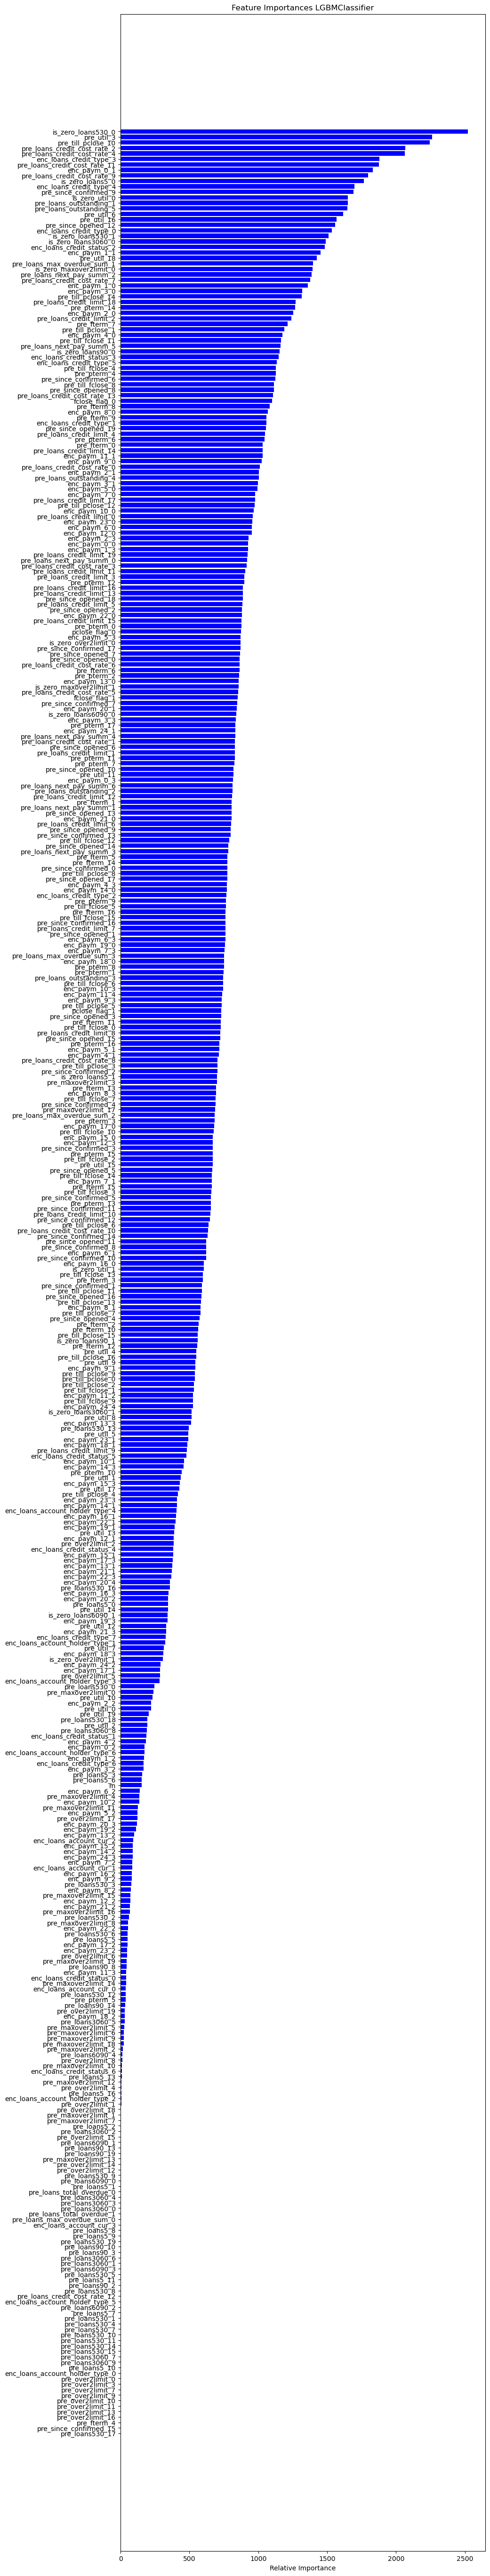

In [17]:
import matplotlib.pyplot as plt
features = X_train.columns
importances = LGBM_cl.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 70))
plt.title('Feature Importances LGBMClassifier')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [28]:
# список фич, не оказавших влияния
not_imp_features = [features[i] for i in indices if importances[i] == 0]
not_imp_features

['pre_loans530_17',
 'pre_since_confirmed_15',
 'pre_fterm_4',
 'pre_over2limit_16',
 'pre_over2limit_13',
 'pre_over2limit_11',
 'pre_over2limit_10',
 'pre_over2limit_9',
 'pre_over2limit_7',
 'pre_over2limit_3',
 'pre_over2limit_0',
 'enc_loans_account_holder_type_0',
 'pre_loans5_10',
 'pre_loans3060_9',
 'pre_loans3060_7',
 'pre_loans530_15',
 'pre_loans530_14',
 'pre_loans530_11',
 'pre_loans530_10',
 'pre_loans530_7',
 'pre_loans530_4',
 'pre_loans530_1',
 'pre_loans5_7',
 'pre_loans6090_2',
 'enc_loans_account_holder_type_5',
 'pre_loans_credit_cost_rate_12',
 'pre_loans530_8',
 'pre_loans90_2',
 'pre_loans5_11',
 'pre_loans530_5',
 'pre_loans6090_3',
 'pre_loans3060_1',
 'pre_loans3060_6',
 'pre_loans90_3',
 'pre_loans90_10',
 'pre_loans530_19',
 'pre_loans5_9',
 'pre_loans5_8',
 'enc_loans_account_cur_3',
 'pre_loans_max_overdue_sum_0',
 'pre_loans_total_overdue_1',
 'pre_loans3060_0',
 'pre_loans3060_3',
 'pre_loans3060_4',
 'pre_loans_total_overdue_0',
 'pre_loans5_1',
 'pre

In [33]:
X_new = X_train.drop(columns=not_imp_features)
LGBM_cl = LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)
LGBM_cl.fit(X_train, y_train)
preds = LGBM_cl.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6096
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.7633884793006414

In [42]:
X_train_new = X_train.drop(columns=not_imp_features)
X_test_new = X_test.drop(columns=not_imp_features)
LGBM_cl = LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)
LGBM_cl.fit(X_train_new, y_train)
preds = LGBM_cl.predict(X_test_new)
print(roc_auc_score(y_test, preds))
print(confusion_matrix(y_test, preds))

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6096
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[[384193 194519]
 [  5843  15445]]


In [43]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    578712
           1       0.07      0.73      0.13     21288

    accuracy                           0.67    600000
   macro avg       0.53      0.69      0.46    600000
weighted avg       0.95      0.67      0.77    600000



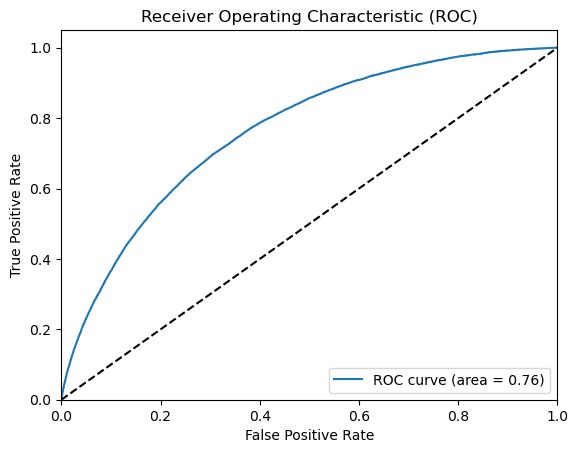

In [35]:
# Построение ROC-кривой
from sklearn.metrics import roc_curve
# Получение значения ROC AUC
auc = roc_auc_score(y_test, preds)

fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### на данной модели в конце проверим пару новых вич и соберем итоговый пайплайн

#### Создаем пайплайн для GaussianNB

In [45]:
from sklearn.naive_bayes import GaussianNB
GaussianNB_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", GaussianNB())])

score = cross_validate(GaussianNB_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(GaussianNB).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.6741,     roc_auc_std: 0.0016,    info: {'fit_time': array([2.67648911, 2.34385777, 2.26294827, 2.17570186, 2.16681695]), 'score_time': array([0.34566712, 0.32879591, 0.29072237, 0.29173613, 0.29677463]), 'test_score': array([0.67463992, 0.67149667, 0.67360246, 0.6745236 , 0.67628142])}


#### Создаем пайплайн для MLPclassifier

In [71]:
from sklearn.neural_network import MLPClassifier
MLPClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", MLPClassifier())])

score = cross_validate(MLPClassifier_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(MLPClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.6776,     roc_auc_std: 0.0039,    info: {'fit_time': array([251.25624442, 245.27963758, 249.47661066, 244.61110115]), 'score_time': array([0.21990132, 0.2220192 , 0.21617341, 0.22303081]), 'test_score': array([0.68422125, 0.67581829, 0.67473739, 0.67555714])}


#### Создаем пайплайн для Случайные лес

In [70]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
RandomForestRegressor_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestRegressor())])

score = cross_validate(RandomForestRegressor_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(RandomForestRegressor).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.7327,     roc_auc_std: 0.0011,    info: {'fit_time': array([651.15342641, 647.27633929, 620.3732059 , 610.32564211]), 'score_time': array([1.24525928, 1.20007563, 1.16207266, 1.202914  ]), 'test_score': array([0.73385838, 0.73367224, 0.7318076 , 0.73141332])}


#### Создаем пайплайн для LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
LogisticRegression_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])
score = cross_validate(LogisticRegression_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(LogisticRegression).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: type, roc_auc_mean: 0.7342,     roc_auc_std: 0.0011,    info: {'fit_time': array([4.4507153 , 4.2169385 , 4.09237647, 3.97010231, 4.09610987]), 'score_time': array([0.15645218, 0.14995933, 0.14993   , 0.16056418, 0.16374063]), 'test_score': array([0.73557984, 0.73481238, 0.73355499, 0.73463709, 0.73230667])}


### CatBoost

In [ ]:
from catboost import CatBoostClassifier
CatBoost = CatBoostClassifier()
CatBoostn_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", CatBoostClassifier())])
score = cross_validate(CatBoost, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(CatBoostClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")


model: type, roc_auc_mean: 0.7606,     roc_auc_std: 0.0011, 

In [ ]:
CatBoost = CatBoostClassifier()
param_grid = {'depth': [4, 7, 10],
              'learning_rate': [0.01, 0.1, 1],
              'l2_leaf_reg': [3, 5, 7],
              'iterations': [100, 200, 300],
              'border_count': [32, 64, 128]
              }
grid_search = GridSearchCV(CatBoost, param_grid, scoring='roc_auc', cv=kfold)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_, "score: ", grid_search.best_score_)

Лучшие параметры: {'border_count': 64, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.1} score:  0.7584418211533477

In [ ]:
CatBoost = CatBoostClassifier()
param_grid = {'depth': [10, 15, 20],
              'learning_rate': [0.1],
              'l2_leaf_reg': [7, 9, 15],
              'iterations': [300, 500],
              'border_count': [64]
              }
grid_search = GridSearchCV(CatBoost, param_grid, scoring='roc_auc', cv=kfold)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_, "score: ", grid_search.best_score_)

###### проверка на всей выборке

In [37]:
CatBoost = CatBoostClassifier(border_count = 64, depth = 10, iterations = 300, l2_leaf_reg = 7, learning_rate = 0.1)

score = cross_validate(CatBoost, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')
print(f"model: {type(CatBoostClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

0:	learn: 0.5516755	total: 1.92s	remaining: 9m 34s
1:	learn: 0.4487850	total: 3.85s	remaining: 9m 32s
2:	learn: 0.3732905	total: 5.84s	remaining: 9m 37s
3:	learn: 0.3167507	total: 7.66s	remaining: 9m 26s
4:	learn: 0.2747489	total: 9.58s	remaining: 9m 25s
5:	learn: 0.2438323	total: 11.5s	remaining: 9m 24s
6:	learn: 0.2201205	total: 13.4s	remaining: 9m 21s
7:	learn: 0.2020910	total: 15.3s	remaining: 9m 18s
8:	learn: 0.1885959	total: 17.3s	remaining: 9m 18s
9:	learn: 0.1787106	total: 19.3s	remaining: 9m 18s
10:	learn: 0.1713743	total: 21.3s	remaining: 9m 20s
11:	learn: 0.1658433	total: 23.3s	remaining: 9m 20s
12:	learn: 0.1609407	total: 25.4s	remaining: 9m 19s
13:	learn: 0.1569012	total: 27.4s	remaining: 9m 19s
14:	learn: 0.1537657	total: 29.5s	remaining: 9m 19s
15:	learn: 0.1512609	total: 31.6s	remaining: 9m 20s
16:	learn: 0.1494880	total: 33.6s	remaining: 9m 20s
17:	learn: 0.1480406	total: 35.7s	remaining: 9m 19s
18:	learn: 0.1467690	total: 37.8s	remaining: 9m 18s
19:	learn: 0.1456417	t

In [34]:
CatBoost = CatBoostClassifier()

score = cross_validate(CatBoost, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')
print(f"model: {type(CatBoostClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

Learning rate set to 0.285946
0:	learn: 0.3595152	total: 530ms	remaining: 8m 49s
1:	learn: 0.2342879	total: 944ms	remaining: 7m 51s
2:	learn: 0.1842058	total: 1.36s	remaining: 7m 30s
3:	learn: 0.1631281	total: 1.86s	remaining: 7m 43s
4:	learn: 0.1537293	total: 2.25s	remaining: 7m 28s
5:	learn: 0.1485226	total: 2.7s	remaining: 7m 27s
6:	learn: 0.1456828	total: 3.15s	remaining: 7m 27s
7:	learn: 0.1439679	total: 3.69s	remaining: 7m 38s
8:	learn: 0.1430578	total: 4.15s	remaining: 7m 36s
9:	learn: 0.1423451	total: 4.59s	remaining: 7m 34s
10:	learn: 0.1419413	total: 4.98s	remaining: 7m 27s
11:	learn: 0.1416999	total: 5.32s	remaining: 7m 17s
12:	learn: 0.1412789	total: 5.76s	remaining: 7m 17s
13:	learn: 0.1410740	total: 6.14s	remaining: 7m 12s
14:	learn: 0.1409139	total: 6.51s	remaining: 7m 7s
15:	learn: 0.1407164	total: 6.89s	remaining: 7m 3s
16:	learn: 0.1405803	total: 7.27s	remaining: 7m
17:	learn: 0.1403990	total: 7.72s	remaining: 7m 1s
18:	learn: 0.1402566	total: 8.14s	remaining: 7m
19:	

In [40]:
CatBoost = CatBoostClassifier()
CatBoost.fit(X_train, y_train)
preds = LGBM_cl.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

Learning rate set to 0.0924
0:	learn: 0.6833780	total: 43.5ms	remaining: 43.4s
1:	learn: 0.6752045	total: 85.4ms	remaining: 42.6s
2:	learn: 0.6682939	total: 127ms	remaining: 42.2s
3:	learn: 0.6623088	total: 167ms	remaining: 41.5s
4:	learn: 0.6570297	total: 210ms	remaining: 41.8s
5:	learn: 0.6522287	total: 259ms	remaining: 43s
6:	learn: 0.6483939	total: 303ms	remaining: 42.9s
7:	learn: 0.6447768	total: 345ms	remaining: 42.8s
8:	learn: 0.6411588	total: 388ms	remaining: 42.7s
9:	learn: 0.6384697	total: 428ms	remaining: 42.4s
10:	learn: 0.6353782	total: 475ms	remaining: 42.7s
11:	learn: 0.6328117	total: 519ms	remaining: 42.7s
12:	learn: 0.6305254	total: 560ms	remaining: 42.6s
13:	learn: 0.6284879	total: 602ms	remaining: 42.4s
14:	learn: 0.6264621	total: 643ms	remaining: 42.2s
15:	learn: 0.6247234	total: 688ms	remaining: 42.3s
16:	learn: 0.6230044	total: 729ms	remaining: 42.2s
17:	learn: 0.6213798	total: 770ms	remaining: 42s
18:	learn: 0.6198594	total: 810ms	remaining: 41.8s
19:	learn: 0.61

0.7578074622232926

### Решающее дерево

In [48]:
from sklearn.tree import DecisionTreeClassifier
TreeCl = DecisionTreeClassifier()
DecisionTree_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", DecisionTreeClassifier())])
score = cross_validate(DecisionTree_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(DecisionTreeClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.5901,     roc_auc_std: 0.0029,    info: {'fit_time': array([14.52157712, 15.51200271, 15.2461915 , 13.64480615, 13.65178227]), 'score_time': array([0.17840576, 0.17025805, 0.15848279, 0.16454792, 0.15699148]), 'test_score': array([0.5918241 , 0.59480276, 0.58725574, 0.58887696, 0.58755173])}


### Метод ближайших соседей

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
KNeighborsClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", KNeighborsClassifier())])
score = cross_validate(KNeighborsClassifier_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(KNeighborsClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.6492,     roc_auc_std: 0.0022,    info: {'fit_time': array([1.48481584, 1.57443762, 1.44676352, 1.46492553]), 'score_time': array([14.19895077, 15.14753795, 15.03106213, 18.15467548]), 'test_score': array([0.64835599, 0.65185979, 0.65062108, 0.64614651])}


### AdaBoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
AdaBoostClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", AdaBoostClassifier())])
score = cross_validate(AdaBoostClassifier_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(AdaBoostClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.7334,     roc_auc_std: 0.0013,    info: {'fit_time': array([33.43241525, 33.55830789, 33.5609901 , 33.80403233, 32.90363598]), 'score_time': array([1.31253338, 1.30026937, 1.37831593, 1.27460003, 1.34055328]), 'test_score': array([0.73528153, 0.73339387, 0.73108693, 0.73366741, 0.7335666 ])}


### GradientBoostingClassifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier() #n_estimators=100, learning_rate=1.0,  max_depth=1, random_state=0)
score = cross_validate(clf, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(GradientBoostingClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")


model: ABCMeta, roc_auc_mean: 0.7460,     roc_auc_std: 0.0011,    info: {'fit_time': array([142.70084715, 143.24533844, 141.15821815, 138.31846094,
       135.17679214]), 'score_time': array([0.16639304, 0.14853287, 0.16696095, 0.14962459, 0.15555072]), 'test_score': array([0.74794145, 0.74579189, 0.74482627, 0.7460192 , 0.74517609])}


In [19]:
GradientBoostingClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", GradientBoostingClassifier())])
score = cross_validate(GradientBoostingClassifier_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(GradientBoostingClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.7459,     roc_auc_std: 0.0011,    info: {'fit_time': array([133.68256092, 135.23238635, 137.06557012, 143.8700726 ,
       225.2368753 ]), 'score_time': array([0.26949692, 0.27856684, 0.26892471, 0.51591587, 0.49263382]), 'test_score': array([0.74794145, 0.7457797 , 0.74482627, 0.7460192 , 0.74517609])}


### Метод опорных векторов

In [21]:
from sklearn.svm import SVC
svc =  SVC()
svc_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC())])
score = cross_validate(svc_pipline, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(SVC).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: ABCMeta, roc_auc_mean: 0.7510,     roc_auc_std: 0.0005,    info: {'fit_time': array([5307.58609653, 4785.25411081, 4263.2805171 , 5840.95785904]), 'score_time': array([ 940.66966867,  962.19220018,  898.82917976, 1302.92375708]), 'test_score': array([0.75080104, 0.75123905, 0.75166208, 0.750308  ])}


##### Результат лучше, чем в большинстве, но время выполнения более 10 часов на даунсемпле. Дальше не использую.

# Вывод:
### лучший результат дала модель LGBMClassifie(после тюнинга), она показала roc_auc_mean: 0.7652, roc_auc_std: 0.0017, на всей выборке по результатам кросс-валидации
### и 0.7634 на тестовой выборке


# Стэкинг

In [ ]:
df_2 = pd.read_parquet('df_2.parquet')
X_train, y_train = df_2[df_2.columns.tolist()[:-1]].astype(np.int8), df_2['flag'].astype(np.int16)
data_test = pd.read_parquet('data_test.parquet')
X_test, y_test = data_test[data_test.columns.tolist()[:-1]].astype(np.int8), data_test['flag'].astype(np.int16)

In [ ]:
from sklearn.feature_selection import SelectKBest,  f_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
estimators = [
    ("LogisticRegression", LogisticRegression()),
    ("LGBMClassifier", LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)),
    ("GaussianNB",GaussianNB()),
    ("KNeighborsClassifier",  KNeighborsClassifier()),
    ("CatBoostClassifier", CatBoostClassifier())
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=AdaBoostClassifier()
)
stacking_classifier

In [45]:
# стэкинг на тренровочных данных
score = cross_validate(stacking_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(stacking_classifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 68119, number of negative: 68127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5951
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 386
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499971 -> initscore=-0.000117
[LightGBM] [Info] Start training from score -0.000117
Learning rate set to 0.084002
0:	learn: 0.6842166	total: 39.1ms	remaining: 39s
1:	learn: 0.6766839	total: 76.9ms	remaining: 38.4s
2:	learn: 0.6701317	total: 116ms	remaining: 38.7s
3:	learn: 0.6646349	total: 154ms	remaining: 38.4s
4:	learn: 0.6596049	total: 193ms	remaining: 38.3s
5:	learn: 0.6551818	total: 235ms	remaining: 39s
6:	learn: 0.6510851	total: 280ms	remaining: 39.8s
7:	learn: 0.6475623	total: 328ms	remaining: 40.6s
8:	learn: 0.6442606	total: 368ms	remaining: 40.6s
9:	learn: 0.6411302	total:

In [46]:
stacking_classifier.fit(X_train, y_train)
preds = stacking_classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6096
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.0924
0:	learn: 0.6833780	total: 52ms	remaining: 51.9s
1:	learn: 0.6752045	total: 102ms	remaining: 51.1s
2:	learn: 0.6682939	total: 152ms	remaining: 50.6s
3:	learn: 0.6623088	total: 202ms	remaining: 50.4s
4:	learn: 0.6570297	total: 256ms	remaining: 51s
5:	learn: 0.6522287	total: 307ms	remaining: 50.9s
6:	learn: 0.6483939	

0.7629906211215852

In [6]:
estimators = [
    ("LGBMClassifier", LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1)),
    ("GaussianNB",GaussianNB()),
    ("KNeighborsClassifier",  KNeighborsClassifier())
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier()
)
stacking_classifier

In [9]:
# стэкинг на тренровочных данных
score = cross_validate(stacking_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(stacking_classifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

  File "d:\Program files\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 68119, number of negative: 68127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5951
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 386
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499971 -> initscore=-0.000117
[LightGBM] [Info] Start training from score -0.000117
[LightGBM] [Info] Number of positive: 54495, number of negative: 54501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5847
[LightGBM] [Info] Number of data points in the train set: 108996, number of used features: 385
[LightGBM] [In

In [24]:
estimators = [
    ("LogisticRegression", LogisticRegression()),
    ("LGBMClassifier", LGBMClassifier()),
    ("GaussianNB",GaussianNB()),
    ("KNeighborsClassifier",  KNeighborsClassifier())
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier()
)
stacking_classifier

In [25]:
# стэкинг на тренровочных данных
score = cross_validate(stacking_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(stacking_classifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 68119, number of negative: 68127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5951
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 386
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499971 -> initscore=-0.000117
[LightGBM] [Info] Start training from score -0.000117
[LightGBM] [Info] Number of positive: 54495, number of negative: 54501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5847
[LightGBM] [Info] Number of data points in the train set: 108996, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499972 -> initscore=-0.000110
[LightGBM] [Info] Start training from score -0.000110
[LightGB

In [18]:
estimators = [
    ("LGBMClassifier",LGBMClassifier()),
    ("Xgboost",  XGBClassifier()),
    ("GaussianNB", GaussianNB()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("KNeighborsClassifier", KNeighborsClassifier()),
    ("CatBoostClassifier", CatBoostClassifier())
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    verbose=True,
)
stacking_classifier

In [14]:
score = cross_validate(stacking_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(stacking_classifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

model: StackingClassifier, roc_auc_mean: 0.7614,     roc_auc_std: 0.0012,    info: {'fit_time': array([402.18264318, 380.51021409, 405.94565058, 319.81165648,
       407.97147989]), 'score_time': array([106.57512236,  80.5939374 ,  78.81545687,  77.27191305,
        74.7814784 ]), 'test_score': array([0.7616129 , 0.76299717, 0.75936301, 0.76226735, 0.76090656])}


In [19]:
stacking_classifier.fit(X_train, y_train)
preds = stacking_classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

  File "d:\Program files\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


0.7624322788666789

In [22]:
estimators = [
    ("LogisticRegression",  LogisticRegression()),
    ("LGBMClassifier",LGBMClassifier()),
    ("Xgboost",  XGBClassifier()),
    ("GaussianNB", GaussianNB()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("KNeighborsClassifier", KNeighborsClassifier())    
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=CatBoostClassifier(),
    n_jobs=-1,
    verbose=True)
stacking_classifier

In [23]:
stacking_classifier.fit(X_train, y_train)
preds = stacking_classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)

Learning rate set to 0.0924
0:	learn: 0.6735270	total: 163ms	remaining: 2m 43s
1:	learn: 0.6577089	total: 175ms	remaining: 1m 27s
2:	learn: 0.6448070	total: 184ms	remaining: 1m 1s
3:	learn: 0.6339926	total: 196ms	remaining: 48.7s
4:	learn: 0.6252633	total: 214ms	remaining: 42.5s
5:	learn: 0.6178691	total: 225ms	remaining: 37.3s
6:	learn: 0.6118354	total: 236ms	remaining: 33.5s
7:	learn: 0.6068798	total: 245ms	remaining: 30.4s
8:	learn: 0.6026962	total: 257ms	remaining: 28.3s
9:	learn: 0.5995540	total: 268ms	remaining: 26.5s
10:	learn: 0.5969308	total: 279ms	remaining: 25.1s
11:	learn: 0.5946839	total: 289ms	remaining: 23.8s
12:	learn: 0.5927504	total: 300ms	remaining: 22.8s
13:	learn: 0.5912279	total: 311ms	remaining: 21.9s
14:	learn: 0.5899346	total: 322ms	remaining: 21.1s
15:	learn: 0.5887410	total: 333ms	remaining: 20.5s
16:	learn: 0.5878795	total: 345ms	remaining: 19.9s
17:	learn: 0.5870381	total: 357ms	remaining: 19.5s
18:	learn: 0.5863774	total: 367ms	remaining: 18.9s
19:	learn: 

0.7581754720816634

# Вывод
### С помощью стэкинга не удалось улучшить метрику

# Часть 2 
## 3 новых фичи и Итоговый пайплайн

In [105]:
# путь до данных на компьютере
path = 'train_data/'

In [106]:
# импорты
import pandas as pd
import os
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder

In [107]:
# список категориальных признаков (для ohe кодирования)
categorical_features = ['pre_since_opened','pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
               'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
               'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3',
               'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10',
               'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
               'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
               'enc_loans_account_holder_type','enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur', 
               'pre_loans_total_overdue', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 
               'is_zero_loans6090',  'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit','pclose_flag', 'fclose_flag'
               ]

In [108]:
# список бинарных признаков(+ id и rn + новые фичи)
Bin_feats = ['id','rn', 'pre_loans30', 'total_pre_loans', 'quant_over_loans' ]

In [109]:
#Ф-ция для создания датафрейма с категориальными признаками
def categorical_select(data):
    return data[categorical_features]
categorical_selector = FunctionTransformer(categorical_select, validate=False)

In [110]:
pre_loans30_ = ['pre_loans3060', 'pre_loans6090', 'pre_loans90']
all_pre_loans_ = [ 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90']

In [111]:
#Ф-ция для создания датафрейма с некатегориальными признаками(+ id и rn + новые фичи)
def bin_select(data):
    data['pre_loans30'] = data[pre_loans30_].sum(axis=1)
    data['total_pre_loans'] = data[all_pre_loans_].sum(axis=1)
    data['quant_over_loans'] = data['total_pre_loans'].apply(lambda x: 0 if x == 0 else 1)
    return data[Bin_feats]
bin_selector = FunctionTransformer(bin_select, validate=False)

In [112]:
# Кастомный OHE, который выводит датафрейм, а не матрицу
ohe = OneHotEncoder()
class OneHotEncodingDf(OneHotEncoder):
    """DataFrame Wrapper around OneHotEncoding"""
    def __init__(self, drop=None, sparse=False, handle_unknown='ignore'):
        super(OneHotEncodingDf, self).__init__(drop=drop,
                                               sparse=sparse,
                                               handle_unknown=handle_unknown
                                              )

    def transform(self, X, y=None):
        z = super(OneHotEncodingDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=self.get_feature_names_out())
    
ohe_df = OneHotEncodingDf()

In [113]:
# Препроцессор для категориальных признаков
categorical_preprocessor = Pipeline([
    ("categorical_selector", categorical_selector),
    ("ohe", ohe_df)
])

In [114]:
# Препроцессор с некатегориальными признаками(+ id и rn + новые фичи)
bin_preprocessor = Pipeline([
    ("bin_selector", bin_selector)
])

In [115]:
# Ф-ци агрегации, для суммирования значений по id, подсчета количества rn(кредитных продуктов)
def agg_func(data):
    cols = data.columns[2:]
    aggregation_dict = {col: 'sum' for col in cols}
    data = data.groupby('id').agg({'rn': 'count', **aggregation_dict}).astype(np.int16).reset_index()
    return data
agg_sum_func = FunctionTransformer(agg_func, validate=False)

In [116]:
# препроцессор для агрегации
agg_sum_preprocessor = Pipeline([
    ("aggregation", agg_sum_func)
])

In [117]:
# Кастомный Union, чтобы на выходе получать датафрейм, а не матрицу.
from joblib import Parallel, delayed 
from scipy import sparse

from sklearn.pipeline import (
    _fit_transform_one,
    _transform_one,
)

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [118]:
# Union для параллельной обработки бинарных признаков и категориальных
feature_union = PandasFeatureUnion([
    ("bin_preprocessor", bin_preprocessor),
    ("categorical_preprocessor", categorical_preprocessor)
])

In [119]:
# итоговый пайплайн для предобработки загружаемых данных(сразу возвращает датафрейм, а не матрицу)
prepare_dataset = Pipeline([
    ("preprocessing", feature_union),
    ("aggregation", agg_sum_preprocessor) #Агрегация
])

In [120]:
# читаем датасет

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [121]:
# Функция для чтения и преобразования датасета
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных
        transactions_frame = prepare_dataset.fit_transform(transactions_frame) #га выгоде получаем датасет после ohe и агрегации

   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames) 

In [122]:
# Собираем датасет из частей
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once = 1,
                                     num_parts_total = 12)

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq


### Я добавил 3 признака
#### pre_loans30 - количество просрочек более 30 мес
#### total_pre_loans - общее количество просрочек
#### quant_over_loans - количество кредитов, по которым допущены просрочки

In [123]:
# читаем целевую переменную
targets = pd.read_csv('train_target.csv')
targets.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [124]:
# добавляем целевую переменную в датасет
df_merged = data.merge(targets[['id', 'flag']], on='id')
df_merged

id  rn  pre_loans30  total_pre_loans  quant_over_loans  \
0              0  10          170              390                10   
1              1  14          238              546                14   
2              2   3           51              103                 3   
3              3  15          255              585                15   
4              4   1           17               39                 1   
...          ...  ..          ...              ...               ...   
2999995  2499995  14          238              546                14   
2999996  2499996   5           85              195                 5   
2999997  2499997  14          238              546                14   
2999998  2499998   7          119              273                 7   
2999999  2499999  15          255              585                15   

         pre_since_opened_0  pre_since_opened_1  pre_since_opened_2  \
0                         0                   1                   1   
1                         0                   0                   1   
2                         1                   0                   0   
3                         0                   3                   1   
4                         0                   0                   0   
...                     ...                 ...                 ...   
2999995                   1                   1                   0   
2999996                   0                   3                   0   
2999997                   0                   1                   0   
2999998                   0                   0                   0   
2999999                   2                   0                   2   

         pre_since_opened_3  pre_since_opened_4  ...  pre_loans530_9  \
0                         1                   1  ...             NaN   
1                         0                   0  ...             NaN   
2                         0                   0  ...             NaN   
3                         0                   2  ...             NaN   
4                         0                   0  ...             NaN   
...                     ...                 ...  ...             ...   
2999995                   0                   0  ...             0.0   
2999996                   1                   0  ...             0.0   
2999997                   1                   0  ...             0.0   
2999998                   1                   0  ...             0.0   
2999999                   3                   1  ...             0.0   

         pre_loans_max_overdue_sum_0  pre_loans_total_overdue_1  \
0                                NaN                        NaN   
1                                NaN                        NaN   
2                                NaN                        NaN   
3                                NaN                        NaN   
4                                NaN                        NaN   
...                              ...                        ...   
2999995                          NaN                        NaN   
2999996                          NaN                        NaN   
2999997                          NaN                        NaN   
2999998                          NaN                        NaN   
2999999                          NaN                        NaN   

         pre_loans3060_0  pre_loans3060_3  pre_loans3060_4  pre_loans6090_0  \
0                    NaN              NaN              NaN              NaN   
1                    NaN              NaN              NaN              NaN   
2                    NaN              NaN              NaN              NaN   
3                    NaN              NaN              NaN              NaN   
4                    NaN              NaN              NaN              NaN   
...                  ...              ...              ...              ...   
2999995              0.0              NaN              NaN              N

In [125]:
from sklearn.impute import SimpleImputer

def replace_missing_with_zero(df):
    # Определение индексов колонок, в которых есть пропущенные значения
    columns_with_missing_values = df.columns[df.isnull().any()].tolist()

    # Инициализация SimpleImputer для замены пропущенных значений на 0
    imputer = SimpleImputer(strategy='constant', fill_value=0)

    # Замена пропущенных значений на 0
    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

    return df

replace_Nan_func = FunctionTransformer(replace_missing_with_zero, validate=False)

In [126]:
# препроцессор для удаления пропусков в итоговом датасете
replace_Nan_preprocessor = Pipeline([
    ("remove_Nan", replace_Nan_func)
])

In [127]:
# Заполняем признаки с пустыми строками и удаляем id
df_merged = replace_Nan_preprocessor.fit_transform(df_merged)

In [128]:
df_merged.to_parquet('df_merged_final_FEATS.parquet')

In [2]:
df_merged = pd.read_parquet('df_merged_final_FEATS.parquet')

# Визуализация

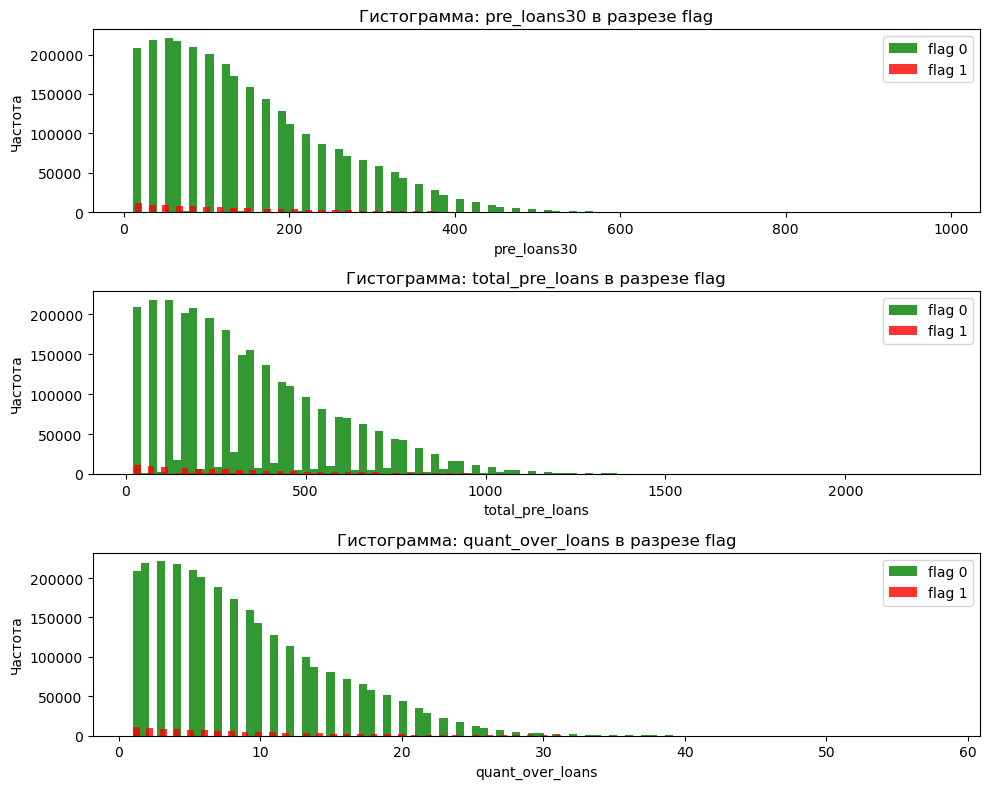

In [5]:
import matplotlib.pyplot as plt

# Получаем уникальные значения "flag"
unique_flags = df_merged['flag'].unique()

# Создаем гистограмму для каждого уникального значения "flag"
cols = ['pre_loans30', 'total_pre_loans', 'quant_over_loans']

fig, ax = plt.subplots(len(cols), 1, figsize=(10, 8))  # Создаем общую область для графиков

for i, col in enumerate(cols):
    for flag in unique_flags:
        if flag == 1:
            color = 'r'  # Красный цвет
        else:
            color = 'g'  # Зеленый цвет
        ax[i].hist(df_merged[df_merged['flag'] == flag][col], alpha=0.8, label=f'flag {flag}', bins=100, color=color)  # Построение гистограммы
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Частота')
        ax[i].set_title(f'Гистограмма: {col} в разрезе flag')
        ax[i].legend()

plt.tight_layout()
plt.show()

### Распределение этих признаков примернотакое же как и в начально анализе

<Axes: >

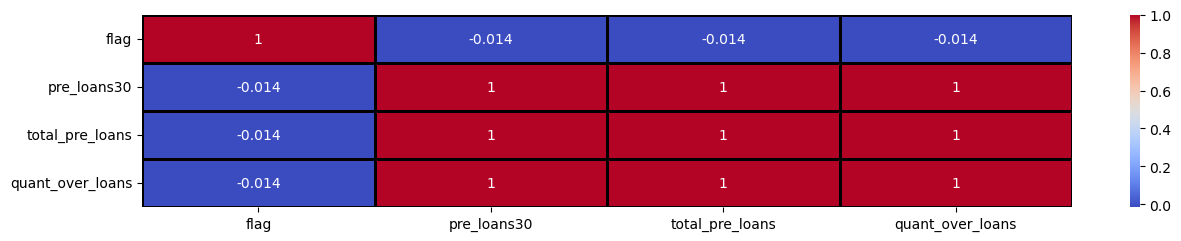

In [135]:
import seaborn as sns
new_feats =  ['flag', 'pre_loans30', 'total_pre_loans', 'quant_over_loans']

fig, ax = plt.subplots(figsize=(15, 2.5))
sns.heatmap(df_merged[new_feats].corr(), annot = True,cmap= 'coolwarm', linewidths=1, linecolor='black')

### корреляция этих признаков так же минимальна

# 3) Делим данные на train и test

In [7]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

data_train, data_test = train_test_split(df_merged, test_size=0.2, stratify=df_merged['flag'], random_state=RANDOM_SEED)

In [8]:
data_test.to_parquet('data_test_final_FEATS.parquet')

In [9]:
from sklearn.utils import resample

df_min = data_train[data_train['flag'] == 1]
df_maj = data_train[data_train['flag'] == 0]

In [10]:
RANDOM_SEED = 1
df_maj_downsample = resample(df_maj, replace=False, n_samples=len(df_min), random_state=RANDOM_SEED)

print(df_maj_downsample.shape)
print(df_min.shape)

(85154, 425)
(85154, 425)


In [11]:
df_2 = pd.concat([df_maj_downsample, df_min], ignore_index=True).sample(frac=1.)
df_2.to_parquet('df_2_final_FEATS.parquet')# выборка не стандартизированная с даунсемплом

# 4) ML

In [2]:
import numpy as np
df_2 = pd.read_parquet('df_2_final_FEATS.parquet')
X_train, y_train = df_2[df_2.columns.tolist()[:-1]].astype(np.int16), df_2['flag'].astype(np.int16)

In [3]:
data_test = pd.read_parquet('data_test_final_FEATS.parquet')
X_test, y_test = data_test[data_test.columns.tolist()[:-1]].astype(np.int16), data_test['flag'].astype(np.int16)

In [4]:
df_merged  = pd.read_parquet('df_merged_final_FEATS.parquet').astype(np.int16)

In [5]:
target = ['flag']  # целевая переменная
id = ['id']
# Бинарные признаки
bin_features = [
    col for col in df_2.columns if (df_2[col].nunique() == 2) & (col not in target + id)
]

# Числовые признаки
numerical_features = [
    col for col in df_2.columns if  col not in bin_features + target + id
]

all_features = bin_features + numerical_features
len(all_features)

423

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import numpy as np

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
def bin_select(data):
    return data
bin_selector = FunctionTransformer(bin_select, validate=False)

In [9]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all"))
])
bin_transformer = Pipeline([
    ("bin_selector", bin_selector)
])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("bin", bin_transformer, bin_features)
])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

LGBMClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1))])

In [47]:
score = cross_validate(LGBMClassifier_pipline, X_train[all_features], y_train, cv=kfold, scoring='roc_auc')
print(f"model: {type(LGBMClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 68206, number of negative: 68040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6829
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500609 -> initscore=0.002437
[LightGBM] [Info] Start training from score 0.002437
[LightGBM] [Info] Number of positive: 68140, number of negative: 68106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6806
[LightGBM] [Info] Number of data points in the train set: 136246, number of used features: 390
[LightGBM] [Info

In [36]:
score = cross_validate(LGBMClassifier_pipline, df_merged[all_features], df_merged['flag'], cv=kfold, scoring='roc_auc')
print(f"model: {type(LGBMClassifier).__name__}, roc_auc_mean: {score['test_score'].mean():.4f}, \
    roc_auc_std: {score['test_score'].std():.4f},\
    info: {score}")

[LightGBM] [Info] Number of positive: 85088, number of negative: 2314912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.620305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6727
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 387
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035453 -> initscore=-3.303441
[LightGBM] [Info] Start training from score -3.303441
[LightGBM] [Info] Number of positive: 84982, number of negative: 2315018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6791
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 387
[LightGB

In [10]:
LGBMClassifier_pipline.fit(X_train[all_features], y_train)
preds = LGBMClassifier_pipline.predict_proba(X_test[all_features])[:,1]
print(roc_auc_score(y_test, preds))

  File "d:\Program files\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6934
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.763534358544153


### По результатам проверки на всей выборке, можно сделать вывод, что модель не переобучилась. Необходимая метрика > 0.75 получена
### без фич было 0.7633884793006414, с новыми фичами стало 0.763534358544153
### прирост примерно 0.0002

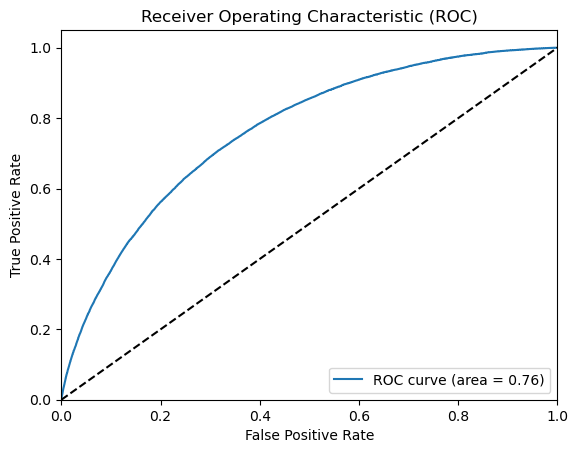

In [50]:
# Построение ROC-кривой
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Получение значения ROC AUC
auc = roc_auc_score(y_test, preds)

fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 5) Сохраняем итоговый пайплайн и предикты с тестовой выборки

In [52]:
LGBMClassifier_pipline.fit(X_train[all_features], y_train)
preds = LGBMClassifier_pipline.predict(X_test[all_features])
df_preds = pd.DataFrame(data = {
    'id' : data_test['id'],
    'flag' : preds    
})
df_preds

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6934
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


id  flag
2405954  1905954     0
1684267  1184267     0
1443688   943688     1
662392   2662392     0
110172    110172     0
...          ...   ...
1975817  1475817     0
1729276  1229276     1
2832884  2332884     0
1701304  1201304     0
444434    444434     0

[600000 rows x 2 columns]

In [53]:
df_preds.to_parquet('df_preds.parquet')

In [ ]:
# Не используем
#import pickle
#from datetime import datetime
#import dill
#best = roc_auc_score(y_test, preds)
#LGBMClassifier_pipline.fit(df_merged[all_features], df_merged['flag'])
#with open('model.pkl', 'wb') as file:
    dill.dump({
            'model': "model",
            'metadata': {
                'name': 'Defolt prediction model',
                'author': 'Alexandr Semeniuk',
                'version': 1,
                'date': datetime.now(),
                'type': type(LGBMClassifier_pipline.named_steps["classifier"]).__name__,
                'roc_auc': best
            }
        }, file, recurse=True)

In [28]:
with open("pipeline.pkl", "wb") as f:
    pickle.dump(LGBMClassifier_pipline, f)

In [29]:
with open('pipeline.pkl', 'rb') as file:
    trained_pipeline = pickle.load(file)

In [35]:
trained_pipeline.fit(X_train[all_features], y_train)

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6934
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['rn',
                                                                    'pre_loans30',
                                                                    'total_pre_loans',
                                                                    'quant_over_loans',
                                                                    'pre_since_opened_0',
                                                                    'pre_since_opened_1',
                                                                    'pre_since_opened_2',
                                                                    'pre_since_opened_3',
                                                                    'pre_since_opened_4',
                                                                    '...
                                                                    'pre_loans5_1',
                                                                    'pre_loans530_19',
                                                                    'pre_loans3060_1',
                                                                    'pre_loans90_2',
                                                                    'pre_loans5_8',
                                                                    'pre_loans5_9',
                                                                    'pre_loans530_5',
                                                                    'pre_loans90_3',
                                                                    'pre_loans90_10',
                                                                    'pre_loans530_9',
                                                                    'pre_loans_max_overdue_sum_0',
                                                                    'pre_loans_total_overdue_1',
                                                                    'pre_loans3060_0'])]))])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.01, max_depth=21,
                                n_estimators=2000, num_leaves=122,
                                reg_lambda=1))])

In [36]:
preds = trained_pipeline.predict(X_test[all_features])
preds

array([0, 0, 1, ..., 0, 0, 0], dtype=int16)

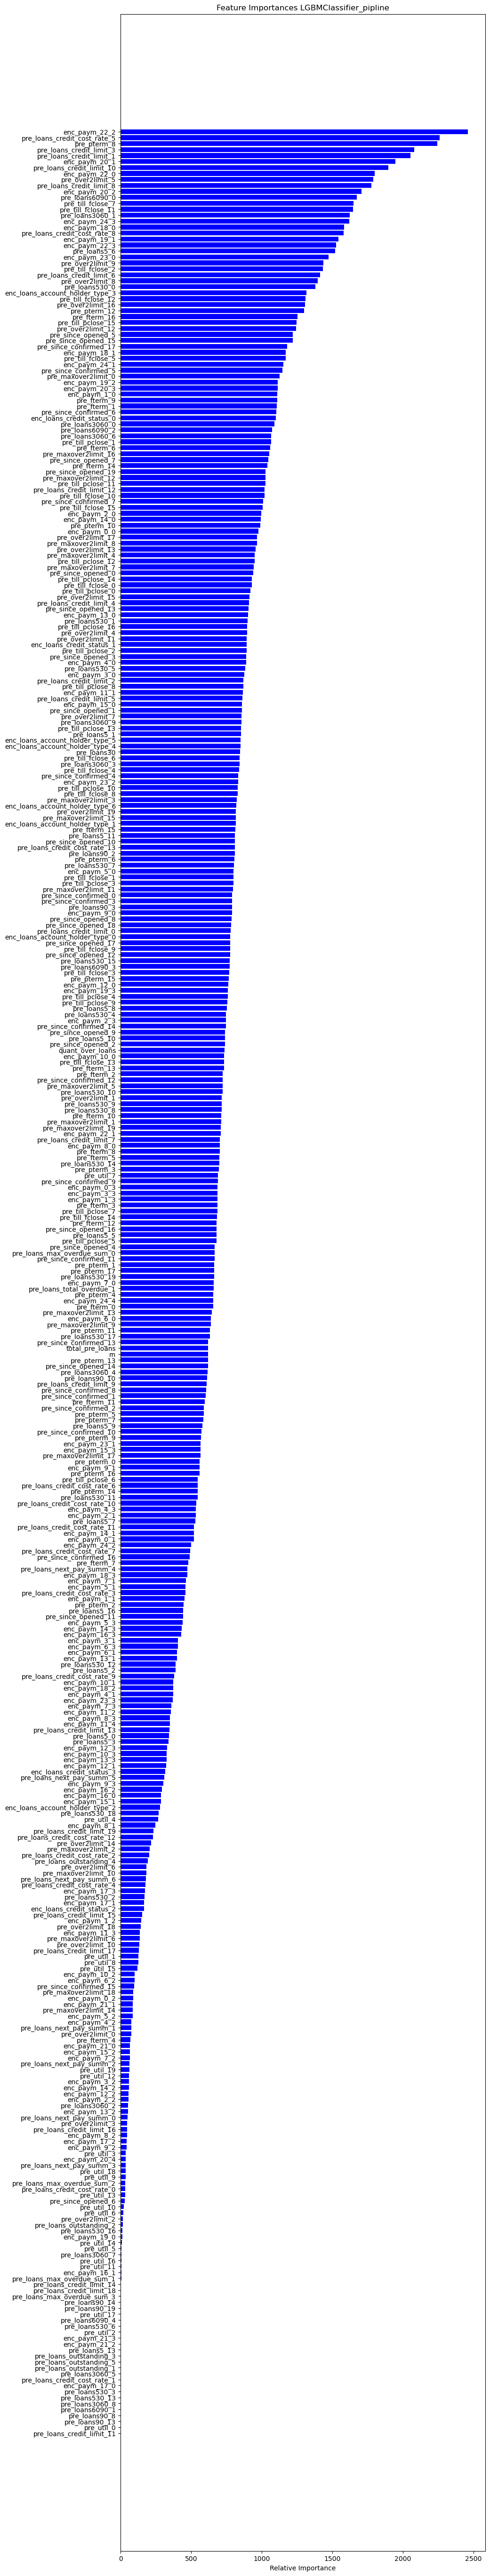

In [34]:
import matplotlib.pyplot as plt
features = all_features
importances = LGBMClassifier_pipline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 70))
plt.title('Feature Importances LGBMClassifier_pipline')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [35]:
not_imp_features = [features[i] for i in indices if importances[i] == 0]
not_imp_features

['pre_loans_credit_limit_11',
 'pre_util_0',
 'pre_loans90_13',
 'pre_loans90_8',
 'pre_loans6090_1',
 'pre_loans3060_8',
 'pre_loans530_13',
 'pre_loans530_3',
 'enc_paym_17_0',
 'pre_loans_credit_cost_rate_1',
 'pre_loans3060_5',
 'pre_loans_outstanding_1',
 'pre_loans_outstanding_5',
 'pre_loans_outstanding_3',
 'pre_loans5_13',
 'enc_paym_21_2',
 'enc_paym_21_3']

## Пайплайн(без нулевых фич)

In [35]:
target = ['flag']  # целевая переменная
id = ['id']
not_imp_features = ['pre_loans_credit_limit_11', 'pre_util_0', 'pre_loans90_13', 'pre_loans90_8', 'pre_loans6090_1',
                    'pre_loans3060_8', 'pre_loans530_13', 'pre_loans530_3', 'enc_paym_17_0', 'pre_loans_credit_cost_rate_1',
                    'pre_loans3060_5', 'pre_loans_outstanding_1', 'pre_loans_outstanding_5', 'pre_loans_outstanding_3',
                    'pre_loans5_13', 'enc_paym_21_2', 'enc_paym_21_3']

# Бинарные признаки
bin_features = [
    col for col in df_2.columns if (df_2[col].nunique() == 2) & (col not in target + id + not_imp_features)
]

# Числовые признаки
numerical_features = [
    col for col in df_2.columns if  col not in bin_features + target + id + not_imp_features
]

all_features = bin_features + numerical_features
len(all_features)

406

In [39]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all"))
])
bin_transformer = Pipeline([
    ("bin_selector", bin_selector)
])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("bin", bin_transformer, bin_features)
])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

LGBMClassifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LGBMClassifier(learning_rate = 0.01, max_depth = 21, n_estimators = 2000, num_leaves = 122, reg_lambda = 1))])

In [42]:
LGBMClassifier_pipline.fit(X_train.drop(columns=['id']), y_train)
preds = LGBMClassifier_pipline.predict_proba(X_test.drop(columns=['id']))[:,1]
print(roc_auc_score(y_test, preds))

[LightGBM] [Info] Number of positive: 85154, number of negative: 85154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6654
[LightGBM] [Info] Number of data points in the train set: 170308, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.7616898333029376


# После удаления нулевых фич, метрика становится хуже. Поэтому оставляем.